# Preamble

In [2]:
import yaml
import random
import json
import pandas as pd
import seaborn as sns
import numpy as np
import typing
from pathlib import Path
from collections import Counter, defaultdict
import matplotlib
from matplotlib import pyplot as plt
from functools import reduce
import kendall_w.kendall_w as kw
import scipy.stats
from tqdm.auto import tqdm

sns.set_theme()

## Functions to process individual subjects and find subjects within directory

## Playground

## Load in all the data from this batch

In [3]:
if not (
    Path("./cleaned_data/composlang-beh.csv").exists()
    and Path("cleaned_data/metadata.yml").exists()
):
    from behavioral import process_subject, find_subject, compile_data

    df, subject_to_ix, ix_to_subject, item_to_ix, ix_to_item = compile_data()
    metadata = {
        "subject_to_ix": subject_to_ix,
        "ix_to_subject": ix_to_subject,
        "item_to_ix": item_to_ix,
        "ix_to_item": ix_to_item,
    }

    Path("./cleaned_data").mkdir(parents=True, exist_ok=True)
    df.to_csv("cleaned_data/composlang-beh.csv", index=False)
    with open("./cleaned_data/metadata.yml", "w") as f:
        yaml.dump(metadata, f)
else:
    df = pd.read_csv("./cleaned_data/composlang-beh.csv")
    with open("./cleaned_data/metadata.yml", "r") as f:
        metadata = yaml.load(f, Loader=yaml.SafeLoader)

    subject_to_ix = metadata["subject_to_ix"]
    ix_to_subject = metadata["ix_to_subject"]
    item_to_ix = metadata["item_to_ix"]
    ix_to_item = metadata["ix_to_item"]

In [4]:
df

,subject_id,study_id,country,language,gender,age,rt,time_elapsed,trial_index,item,response,trial_type,item_index
0,5c8ee6c36ca70b0001fe979d,637d1591e10c9bfd91689241,Canada,English,Male,64.0,10242,99005,0,spiritual musical,1,crit,0
1,5c8ee6c36ca70b0001fe979d,637d1591e10c9bfd91689241,Canada,English,Male,64.0,8196,107205,1,bad computation,-2,crit,1
2,5c8ee6c36ca70b0001fe979d,637d1591e10c9bfd91689241,Canada,English,Male,64.0,6090,113298,2,religious geology,1,crit,2
3,5c8ee6c36ca70b0001fe979d,637d1591e10c9bfd91689241,Canada,English,Male,64.0,5227,118527,3,impossible chorus,-2,crit,3
4,5c8ee6c36ca70b0001fe979d,637d1591e10c9bfd91689241,Canada,English,Male,64.0,4428,122958,4,eligible grouping,2,crit,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
230225,6287818abba6a55b1d5db5c7,637d1591e10c9bfd91689241,UK,English,Male,22.0,2058,766621,225,architectural abbreviation,-3,crit,16490
230226,6287818abba6a55b1d5db5c7,637d1591e10c9bfd91689241,UK,English,Male,22.0,6590,773212,226,private manifesto,2,crit,16306
230227,6287818abba6a55b1d5db5c7,637d1591e10c9bfd91689241,UK,English,Male,22.0,2008,775221,227,tropical conviction,-3,crit,12342
230228,6287818abba6a55b1d5db5c7,637d1591e10c9bfd91689241,UK,English,Male,22.0,1372,776594,228,fat prison,-3,anti,228


In [3]:
df.columns

Index(['subject_id', 'study_id', 'country', 'language', 'gender', 'age', 'rt',
       'time_elapsed', 'trial_index', 'item', 'response', 'trial_type',
       'item_index'],
      dtype='object')

### First we exclude participants that did the study more than once (why??) >:( 

In [5]:
Counter(
    df.groupby("subject_id")
    .count()
    .sort_values(by="response", ascending=False)["response"]
)

Counter({460: 12, 230: 977})

In [6]:
exclude_subs_repeat = (
    df.groupby("subject_id")
    .count()[df.groupby("subject_id").count()["response"] > 230]
    .reset_index()
    .subject_id
)
exclude_subs_repeat = set(exclude_subs_repeat)
print("excluding subjects:")
print("-" * 64)
for sub in exclude_subs_repeat:
    print(sub, subject_to_ix[sub])

excluding subjects:
----------------------------------------------------------------
615bb35e52d50aa9a2ae6747 176
60214feec65df50cd6837a48 346
5ab65c67f69e940001d8e06c 416
5eea0182104faf000a1c2f57 162
61531f1b1584f67730354ec7 420
5d8c251227fdac00198fd66f 689
614ab9a1c3eb9f981b40c893 279
62728f0c68b9ecf571a2dbd4 63
634688391e61c68f25ca1f82 182
604ce6075c751bc1e1a11dd5 30
613ac40c9efdc7becd2f2149 195
5de42a01a7cb2401ccc682c3 228


In [7]:
df2 = df[~df.subject_id.isin(exclude_subs_repeat)]
df2

,subject_id,study_id,country,language,gender,age,rt,time_elapsed,trial_index,item,response,trial_type,item_index
0,5c8ee6c36ca70b0001fe979d,637d1591e10c9bfd91689241,Canada,English,Male,64.0,10242,99005,0,spiritual musical,1,crit,0
1,5c8ee6c36ca70b0001fe979d,637d1591e10c9bfd91689241,Canada,English,Male,64.0,8196,107205,1,bad computation,-2,crit,1
2,5c8ee6c36ca70b0001fe979d,637d1591e10c9bfd91689241,Canada,English,Male,64.0,6090,113298,2,religious geology,1,crit,2
3,5c8ee6c36ca70b0001fe979d,637d1591e10c9bfd91689241,Canada,English,Male,64.0,5227,118527,3,impossible chorus,-2,crit,3
4,5c8ee6c36ca70b0001fe979d,637d1591e10c9bfd91689241,Canada,English,Male,64.0,4428,122958,4,eligible grouping,2,crit,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
230225,6287818abba6a55b1d5db5c7,637d1591e10c9bfd91689241,UK,English,Male,22.0,2058,766621,225,architectural abbreviation,-3,crit,16490
230226,6287818abba6a55b1d5db5c7,637d1591e10c9bfd91689241,UK,English,Male,22.0,6590,773212,226,private manifesto,2,crit,16306
230227,6287818abba6a55b1d5db5c7,637d1591e10c9bfd91689241,UK,English,Male,22.0,2008,775221,227,tropical conviction,-3,crit,12342
230228,6287818abba6a55b1d5db5c7,637d1591e10c9bfd91689241,UK,English,Male,22.0,1372,776594,228,fat prison,-3,anti,228


In [8]:
agg_dict = {
    # defaultdict(
    # lambda: lambda thing: None, #Counter(thing).most_common(1)[0][0],
    # {
    "item_index": "first",
    "subject_id": "count",
    "response": list,
    "rt": "mean",
    "age": "mean",
    "trial_type": "first",
}
# )
# for c in df.columns:
#     agg_dic[c]

by_item = (
    df2.groupby("item")
    .agg(agg_dict)
    .rename(columns={"subject_id": "count", "response": "responses"})
    .reset_index()
)
by_item["rating"] = by_item["responses"].apply(np.mean)
by_item["responses"] = by_item["responses"].apply(np.array)
by_item.index = by_item.item_index.values

by_item.to_csv("./cleaned_data/composlang-beh_no-dupes_agg-by-item.csv")
by_item

# view = by_item[by_item["subject_id"] < 1000]
# view
# plt.hist2d(view.response, view.subject_id, bins=(7, 10))
# plt.show()

,item,item_index,count,responses,rt,age,trial_type,rating
16273,African aftermath,16273,9,"[-2, -2, 3, 1, 2, 0, 1, 1, 2]",2538.555556,29.000000,crit,0.666667
14988,African bill,14988,7,"[2, 3, -1, -3, -2, -3, 2]",5472.285714,34.857143,crit,-0.285714
4192,African can,4192,10,"[2, -3, -1, 3, 1, 1, -2, 2, 0, 3]",3837.100000,30.300000,crit,0.600000
17362,African catalog,17362,8,"[3, 3, -1, -1, 3, -3, -1, -3]",3491.375000,32.375000,crit,0.000000
4587,African chance,4587,13,"[-2, -3, 3, -1, -2, -3, -3, -1, -2, -3, -2, 1, 0]",4000.000000,33.615385,crit,-1.384615
...,...,...,...,...,...,...,...,...
14860,young socket,14860,9,"[-3, -3, -3, 3, -3, 0, -3, 2, -2]",3758.555556,26.000000,crit,-1.333333
5367,young spacecraft,5367,12,"[2, -3, -2, -1, 0, -3, 3, 3, 0, 2, 0, 1]",4771.583333,26.583333,crit,0.166667
3659,young taxi,3659,12,"[-3, -3, 2, -1, 3, -2, -1, -3, -3, -2, -3, -1]",3828.083333,33.583333,crit,-1.416667
19318,young timing,19318,6,"[-3, -3, -3, 1, -3, -1]",4028.166667,35.000000,crit,-2.000000


### Let's also add in some aggregated statistics to the subject-by-item DataFrame before saving it 

In [9]:
df2 = df2.set_index("item_index")
df2["rating"] = 0
df2["count"] = 0
df2.update(by_item.set_index("item_index")[["count", "rating"]])
df2 = df2.reset_index()
df2

,item_index,subject_id,study_id,country,language,gender,age,rt,time_elapsed,trial_index,item,response,trial_type,rating,count
0,0,5c8ee6c36ca70b0001fe979d,637d1591e10c9bfd91689241,Canada,English,Male,64.0,10242,99005,0,spiritual musical,1,crit,1.214286,14
1,1,5c8ee6c36ca70b0001fe979d,637d1591e10c9bfd91689241,Canada,English,Male,64.0,8196,107205,1,bad computation,-2,crit,1.571429,14
2,2,5c8ee6c36ca70b0001fe979d,637d1591e10c9bfd91689241,Canada,English,Male,64.0,6090,113298,2,religious geology,1,crit,-1.363636,11
3,3,5c8ee6c36ca70b0001fe979d,637d1591e10c9bfd91689241,Canada,English,Male,64.0,5227,118527,3,impossible chorus,-2,crit,0.916667,12
4,4,5c8ee6c36ca70b0001fe979d,637d1591e10c9bfd91689241,Canada,English,Male,64.0,4428,122958,4,eligible grouping,2,crit,1.111111,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224705,16490,6287818abba6a55b1d5db5c7,637d1591e10c9bfd91689241,UK,English,Male,22.0,2058,766621,225,architectural abbreviation,-3,crit,-1.250000,12
224706,16306,6287818abba6a55b1d5db5c7,637d1591e10c9bfd91689241,UK,English,Male,22.0,6590,773212,226,private manifesto,2,crit,2.000000,7
224707,12342,6287818abba6a55b1d5db5c7,637d1591e10c9bfd91689241,UK,English,Male,22.0,2008,775221,227,tropical conviction,-3,crit,-2.500000,8
224708,228,6287818abba6a55b1d5db5c7,637d1591e10c9bfd91689241,UK,English,Male,22.0,1372,776594,228,fat prison,-3,anti,-2.259980,977


In [256]:
df2.to_csv("cleaned_data/composlang-beh_no-dupes.csv", index=False)

In [11]:
df2 = pd.read_csv("cleaned_data/composlang-beh_no-dupes.csv")
df2

,item_index,subject_id,study_id,country,language,gender,age,rt,time_elapsed,trial_index,item,response,trial_type,rating,count
0,0,5c8ee6c36ca70b0001fe979d,637d1591e10c9bfd91689241,Canada,English,Male,64.0,10242,99005,0,spiritual musical,1,crit,1.214286,14
1,1,5c8ee6c36ca70b0001fe979d,637d1591e10c9bfd91689241,Canada,English,Male,64.0,8196,107205,1,bad computation,-2,crit,1.571429,14
2,2,5c8ee6c36ca70b0001fe979d,637d1591e10c9bfd91689241,Canada,English,Male,64.0,6090,113298,2,religious geology,1,crit,-1.363636,11
3,3,5c8ee6c36ca70b0001fe979d,637d1591e10c9bfd91689241,Canada,English,Male,64.0,5227,118527,3,impossible chorus,-2,crit,0.916667,12
4,4,5c8ee6c36ca70b0001fe979d,637d1591e10c9bfd91689241,Canada,English,Male,64.0,4428,122958,4,eligible grouping,2,crit,1.111111,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224705,16490,6287818abba6a55b1d5db5c7,637d1591e10c9bfd91689241,UK,English,Male,22.0,2058,766621,225,architectural abbreviation,-3,crit,-1.250000,12
224706,16306,6287818abba6a55b1d5db5c7,637d1591e10c9bfd91689241,UK,English,Male,22.0,6590,773212,226,private manifesto,2,crit,2.000000,7
224707,12342,6287818abba6a55b1d5db5c7,637d1591e10c9bfd91689241,UK,English,Male,22.0,2008,775221,227,tropical conviction,-3,crit,-2.500000,8
224708,228,6287818abba6a55b1d5db5c7,637d1591e10c9bfd91689241,UK,English,Male,22.0,1372,776594,228,fat prison,-3,anti,-2.259980,977


### See the distribution of how many ratings each item has

In [12]:
view = df2[df2.trial_type == "crit"].groupby("item_index").count()["item"]
view[view < 8]

item_index
34       7
71       5
79       7
80       6
91       6
        ..
20023    3
20024    1
20025    2
20026    1
20027    1
Name: item, Length: 4774, dtype: int64

In [13]:
deficit = sum(8 - view[view < 8].to_numpy())
deficit

10134

In [14]:
deficit / 200 * 12 * (0.5)

304.02

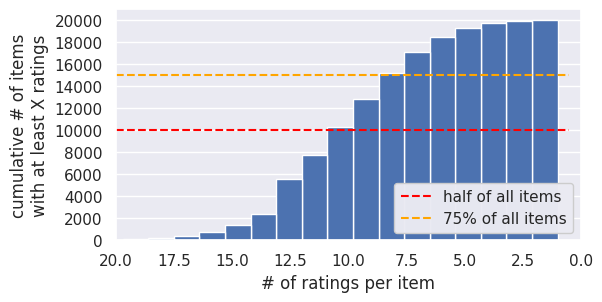

In [15]:
f, a = plt.subplots(figsize=(6, 3))
a.hist(
    df2[df2.trial_type == "crit"].groupby("item_index").count()["item"],
    bins=20,
    cumulative=-1,
)
a.invert_xaxis()

a.set(
    xlabel="# of ratings per item",
    ylabel="cumulative # of items\nwith at least X ratings",
    # xticks=np.arange(1, 21, 2),
    xlim=(20, 0),
)
a.set_yticks(np.arange(0, len(set(df2.item_index)) + 1, 2_000))
a.grid(
    axis="x",
    which="both",
)
a.hlines(
    10_000, 20, 0.5, color="red", linestyle="--", lw=1.5, label="half of all items"
)
a.hlines(
    0.75 * 20_000,
    20,
    0.5,
    color="orange",
    linestyle="--",
    lw=1.5,
    label="75% of all items",
)

a.legend(loc="lower right").get_frame().set_alpha(0.98)
plt.show()

<AxesSubplot:xlabel='response', ylabel='Count'>

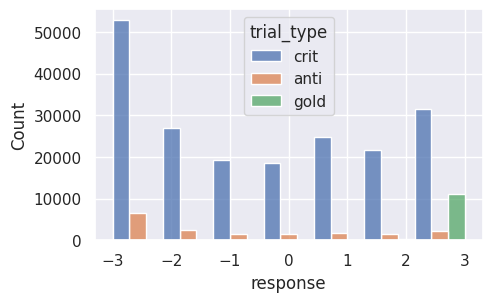

In [144]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.histplot(ax=ax, data=df2, x="response", hue="trial_type", multiple="dodge", bins=7)

## Now let's compute metrics about inter-rater agreement

### Kendall's W

first, we'll need to artificially rank-order the responses per rater based on their rating.

In [212]:
view = df2[df2.trial_type.isin(["anti", "gold"])]
ranks = []
for subj_id in tqdm(view.subject_id.unique(), "rank-ordering items per subject"):
    subj_view = view[view.subject_id == subj_id]

    subj_view = subj_view.sort_values(by="response", ascending=False)
    corrected_ranks = (
        subj_view.reset_index()
        .reset_index()
        .groupby(["response"])
        .min()["index"]
        .to_dict()
    )
    corrected_ranks_ = {
        k: i + 1
        for i, (k, r) in enumerate(
            sorted(corrected_ranks.items(), key=lambda tup: tup[-1])
        )
    }
    rank = subj_view["response"].apply(lambda val: corrected_ranks_[val])
    subj_view["rank"] = rank.astype(int)
    subj_view = subj_view.sort_values(by="item_index")
    ranks.append(np.array(subj_view["rank"]))
    # print(subj_id, len(subj_view))
ranks = np.vstack(ranks).T
ranks

rank-ordering items per subject:   0%|          | 0/977 [00:00<?, ?it/s]

array([[1, 1, 1, ..., 1, 1, 1],
       [2, 1, 2, ..., 2, 1, 2],
       [3, 2, 3, ..., 1, 2, 3],
       ...,
       [4, 5, 3, ..., 1, 2, 3],
       [2, 1, 2, ..., 2, 1, 2],
       [4, 4, 1, ..., 6, 2, 3]])

then, we output the ranks in R-friendly format to use the KendallW implementation in R
taken from https://search.r-project.org/CRAN/refmans/DescTools/html/KendallW.html
```r
library(DescTools)
load("kendallw_input_df.RData")
KendallW(ranks, correct = TRUE, test= TRUE)
```

In [215]:
import pyreadr

ranks_df = pd.DataFrame(ranks)
ranks_df.columns = list(map(lambda i: f"rater{i}", ranks_df.columns))
ranks_df.head()

,rater0,rater1,rater2,rater3,rater4,rater5,rater6,rater7,rater8,rater9,...,rater967,rater968,rater969,rater970,rater971,rater972,rater973,rater974,rater975,rater976
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,2,1,2,2,2,2,1,1,1,1,...,1,2,2,2,1,1,1,2,1,2
2,3,2,3,3,3,3,2,2,2,2,...,2,3,3,3,2,2,2,1,2,3
3,2,1,2,2,2,2,1,1,1,1,...,1,2,2,2,1,1,1,2,1,2
4,4,3,4,4,3,4,3,3,3,3,...,3,1,3,3,3,3,3,3,2,3


In [214]:
pyreadr.write_rdata(
    "cleaned_data/kendallw_input_df.RData",
    df_name="ranks",
    df=ranks_df,
    compress="gzip",
)

```r
> load('kendallw_input_df.RData')
> KendallW(ranks, correct = TRUE, test = TRUE)

       Kendall's coefficient of concordance Wt

data:  ranks
Kendall chi-squared = 12583, df = 29, subjects = 30, raters = 977, p-value < 2.2e-16
alternative hypothesis: Wt is greater 0
sample estimates:
      Wt 
0.444107
```

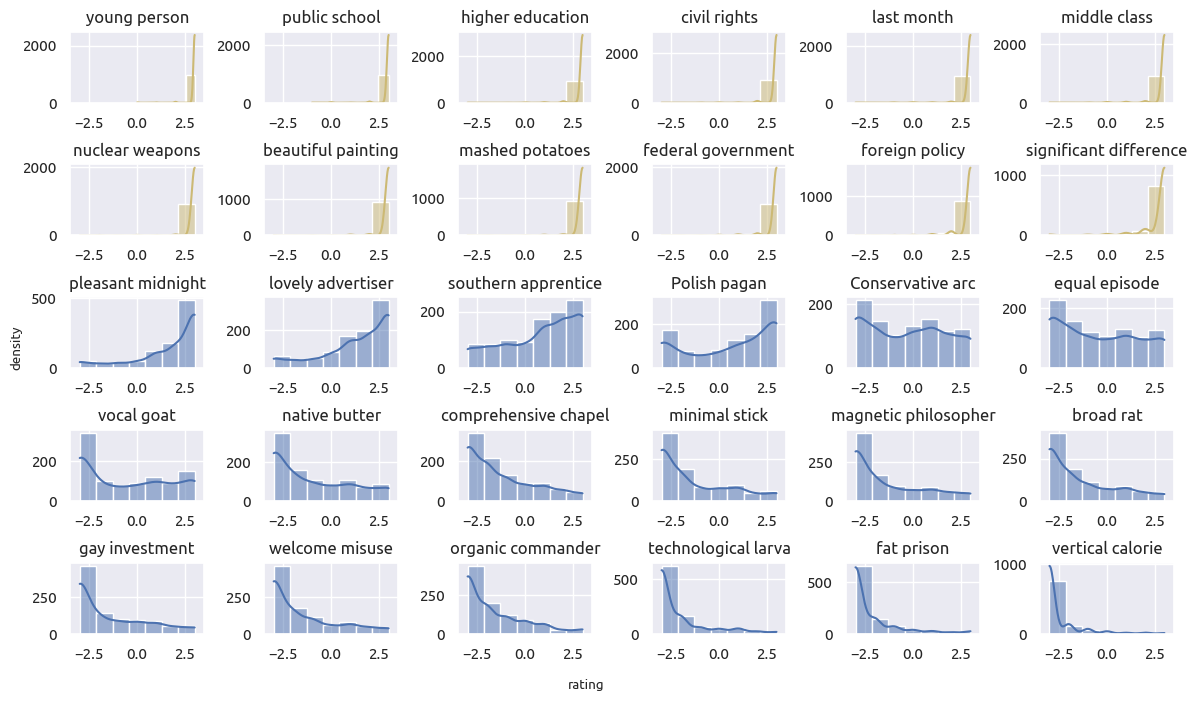

In [104]:
f, a = plt.subplots(5, 6, figsize=(12, 7))

view = df2[df2.trial_type != "crit"]
view = view.sort_values(by="rating", ascending=False)
for i, item_id in enumerate(view.item_index.unique()):
    # figure out which subplot to plot inside
    r, c = i // 6, i % 6

    # a[r, c].plot(
    #     list(
    #         map(lambda x: subject_to_ix[x], view[view.item_index == item_id].subject_id)
    #     ),
    #     view[view.item_index == item_id].response,
    #     # "y." if view[view.item_index == item_id].trial_type.iloc[0] == "gold" else "b.",
    #     "b.",
    #     lw=0.1,
    #     alpha=0.1,
    # )
    # Use seaborn's histplot function to create a density histogram with a KDE line
    sns.histplot(
        view[view.item_index == item_id].response,
        kde=True,
        bins=7,
        ax=a[r, c],
        color="y"
        if view[view.item_index == item_id].trial_type.iloc[0] == "gold"
        else "b",
    )
    a[r, c].set_xlim(-3.5, 3.5)
    a[r, c].set(xlabel=None, ylabel=None)
    # a[r, c].hlines(
    #     y=view[view.item_index == item_id].rating.values[0],
    #     xmin=0 - 100,
    #     xmax=len(view.subject_id.unique()) + 100,
    #     colors="r",
    #     linestyles="-",
    #     lw=1,
    #     alpha=1,
    # )
    a[r, c].set(
        title=f"{view[view.item_index == item_id].item.iloc[0]}",
        # ylim=(-3.5, 3.5),
        # xlabel="subject",
        # ylabel="rating",
        # yticks=np.arange(-3, 3.1, 2),
        # xticks=np.arange(0, len(view.subject_id.unique()), 5),
    )

f.supxlabel("rating")
f.supylabel("density")


font = {
    "family": "Ubuntu",
    # 'weight' : 'bold',
    "size": 8,
}

matplotlib.rc("font", **font)

# plt.rcParams.update({"axes.titlesize": 8})
plt.tight_layout()
plt.show()

## Split groups correlation

In [16]:
def split_groups_corr(
    df_obj: pd.DataFrame,
    random_state: int = None,
    randomize: bool = True,
    group1: slice = slice(0, None, 2),
    group2: slice = slice(1, None, 2),
    all_subj=None,
) -> scipy.stats._stats_py.PearsonRResult:
    """
    computes the correlation between the means of corresponding items across two groups.
    the two groups can be defined flexibly using a slice oject. for instance, this function
    turns into split-halves correlation when the slices bisect the dataset.
    alternatively, this function also supports leave-one-out correlation by making one of
    the slices correspond to a single subject.
    """
    all_subj = list(df_obj.subject_id.unique())

    if randomize:
        if random_state:
            random.seed(random_state)
        random.shuffle(all_subj)

    first_group = set(all_subj[group1])
    second_group = set(all_subj[group2])

    first_group_view = df_obj[df_obj.subject_id.isin(first_group)]
    second_group_view = df_obj[df_obj.subject_id.isin(second_group)]

    # return scipy.stats.pearsonr
    return (
        first_group_view.groupby("item_index").mean()["response"].to_numpy(),
        second_group_view.groupby("item_index").mean()["response"].to_numpy(),
    )


from functools import partial

split_halves_corr = partial(
    split_groups_corr,
    randomize=True,
    group1=slice(0, None, 2),
    group2=slice(1, None, 2),
)


def leave_one_out_corr(
    df_obj: pd.DataFrame,
    subject_id: str,
    numpy: bool = True,
) -> scipy.stats._stats_py.PearsonRResult:
    first_group_view = df_obj.loc[df_obj.subject_id != subject_id]
    second_group_view = df_obj.loc[df_obj.subject_id == subject_id]

    if numpy:
        return (
            first_group_view.groupby("item_index").mean()["response"].to_numpy(),
            second_group_view.groupby("item_index").mean()["response"].to_numpy(),
        )
    else:
        return (
            first_group_view.groupby("item_index").mean(),
            second_group_view.groupby("item_index").mean(),
        )

r=0.998, p=0.000, err=0.017


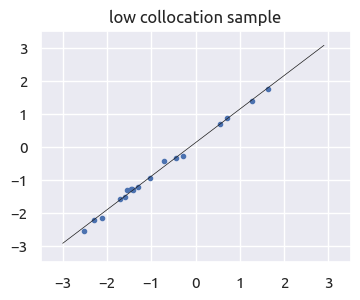

In [295]:
f, a = plt.subplots(figsize=(4, 3))

x, y = split_halves_corr(df2[df2.trial_type.isin(["anti"])], random_state=42)
slope, intercept, r, p, err = scipy.stats.linregress(x, y)

a.plot(x, y, ".")
a.plot((xs := np.arange(-3, 3, 0.1)), intercept + slope * xs, "k-", linewidth=0.5)
a.set(
    xlim=(-3.5, 3.5),
    ylim=(-3.5, 3.5),
    title="low collocation sample",
    xticks=np.arange(-3, 4),
    yticks=np.arange(-3, 4),
)

print(f"r={r:.3f}, p={p:.3f}, err={err:.3f}")

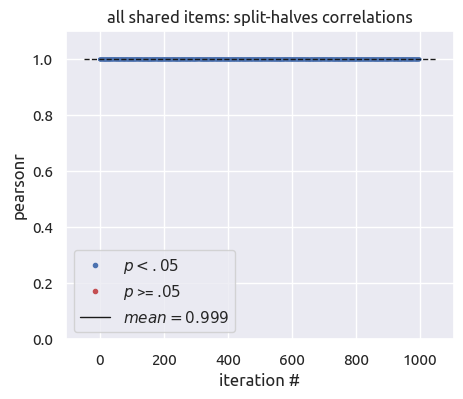

In [303]:
trial_types = ("anti", "gold")
N = 1_000
stats, pvals = [], []
for i in range(N):
    # pr = split_halves_corr(df[df.trial_type.isin([trial_type])], random_state=i)
    # stat, pval = pr.statistic, pr.pvalue
    x, y = split_halves_corr(df2[df2.trial_type.isin(trial_types)], random_state=i)
    slope, intercept, r, p, err = scipy.stats.linregress(x, y)

    stats += [r]
    pvals += [p]

stats, pvals = np.array(stats), np.array(pvals)
c_ix = (pvals < 0.05).astype("int")
# c_ix = np.where(c_ix, '$p<.05$', '$p\\geq.05$')
cmap = matplotlib.colors.ListedColormap(("r", "b"))
c_ix = np.where(c_ix, "b", "r")

f, a = plt.subplots(figsize=(5, 4))
scatter = a.scatter(
    np.arange(N),
    stats,
    s=3,
    c=c_ix,  # cmap=cmap, # label=np.where(c_ix == 1, '$p<.05$', '$p>=.05$')
)
hlines = a.hlines(
    [np.mean(stats)],
    xmin=-N / 20,
    xmax=N + N / 20,
    colors=["k"],
    label="mean={}",
    lw=1,
    linestyles="--",
)

a.set(
    ylabel="pearsonr",
    xlabel="iteration #",
    ylim=(0, 1.1),
    title="all shared items: split-halves correlations",
)

from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker=".", label="$p<.05$", lw=0, color="b"),
    Line2D([0], [0], marker=".", label="$p$ >= $.05$", lw=0, color="r"),
    Line2D([0], [0], marker="", label=f"$mean={np.mean(stats):.3f}$", lw=1, color="k"),
]
a.legend(handles=legend_elements)

plt.show()

In [304]:
x, y = leave_one_out_corr(
    df2[df2.trial_type.isin(["anti"])], "60b8db5feb283b86cce8de9f"
)
x, y

(array([ 1.69467213, -1.26331967, -2.54713115, -1.36065574, -0.28278689,
         0.77766393, -1.55840164, -0.39856557,  1.33094262, -1.65983607,
        -1.43340164, -1.37397541, -2.14856557,  0.62602459, -0.57479508,
        -0.9897541 , -1.36065574, -2.2602459 ]),
 array([ 2., -3., -3., -3., -2., -1., -1.,  1.,  2., -1.,  1., -1., -2.,
         1.,  2., -2.,  1., -2.]))

r=0.907, p=0.000, err=0.062


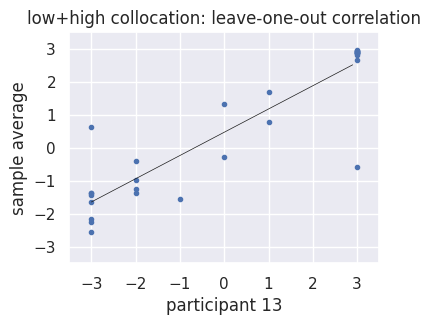

In [17]:
f, a = plt.subplots(figsize=(4, 3))

subj_id = df2.subject_id.unique()[13]
y, x = leave_one_out_corr(df2[df2.trial_type.isin(["anti", "gold"])], subj_id)
slope, intercept, r, p, err = scipy.stats.linregress(x, y)

a.plot(x, y, ".")
a.plot((xs := np.arange(-3, 3, 0.1)), intercept + slope * xs, "k-", linewidth=0.5)
a.set(
    xlim=(-3.5, 3.5),
    ylim=(-3.5, 3.5),
    title="low+high collocation: leave-one-out correlation",
    ylabel="sample average",
    xlabel=f"participant {subject_to_ix[subj_id]}",
    xticks=np.arange(-3, 4),
)

print(f"r={r:.3f}, p={p:.3f}, err={err:.3f}")

In [18]:
df2["loo_corr"] = 0
df2["loo_pval"] = 0
trial_types = ("anti", "gold")
N = len(df2.subject_id.unique())
stats, pvals = [], []
for i, subj_id in enumerate(
    tqdm(df2.subject_id.unique(), desc="computing LOO corr for each subject")
):
    # pr = split_halves_corr(df[df.trial_type.isin([trial_type])], random_state=i)
    # stat, pval = pr.statistic, pr.pvalue
    x, y = leave_one_out_corr(df2[df2.trial_type.isin(trial_types)], subj_id)
    slope, intercept, r, p, err = scipy.stats.linregress(x, y)

    df2.loc[df2.subject_id == subj_id, "loo_corr"] = r
    df2.loc[df2.subject_id == subj_id, "loo_pval"] = p
    stats += [r]
    pvals += [p]

computing LOO corr for each subject:   0%|          | 0/977 [00:00<?, ?it/s]

In [22]:
stats

array([ 0.8115275 ,  0.86159424,  0.57899418,  0.86562502,  0.93072165,
        0.82959614,  0.90242745,  0.86917452,  0.81574733,  0.73340179,
        0.63894518,  0.94621531,  0.84154589,  0.90715443,  0.54209367,
        0.80555356,  0.74541094,  0.70807305,  0.84337415,  0.71522083,
        0.67898719,  0.69499499,  0.8079494 ,  0.84823121,  0.89436519,
        0.95515782,  0.8272639 ,  0.92063991,  0.89002248,  0.8650334 ,
        0.72826838,  0.76666309,  0.85596379,  0.7920233 ,  0.92871032,
        0.90709669,  0.89715277,  0.94997827,  0.84035072,  0.78347421,
        0.85534406,  0.94710002,  0.86194725,  0.9279306 ,  0.93949839,
        0.90994213,  0.91829827,  0.43350861,  0.87730138,  0.86171427,
        0.8845906 ,  0.86190813,  0.91005504,  0.73069154,  0.93754215,
        0.81224252,  0.59011607,  0.86342642,  0.8029813 ,  0.9364325 ,
        0.83586552,  0.75228135,  0.87827273,  0.81504637,  0.92432666,
        0.76013118,  0.82812508,  0.64483173,  0.80302136,  0.82

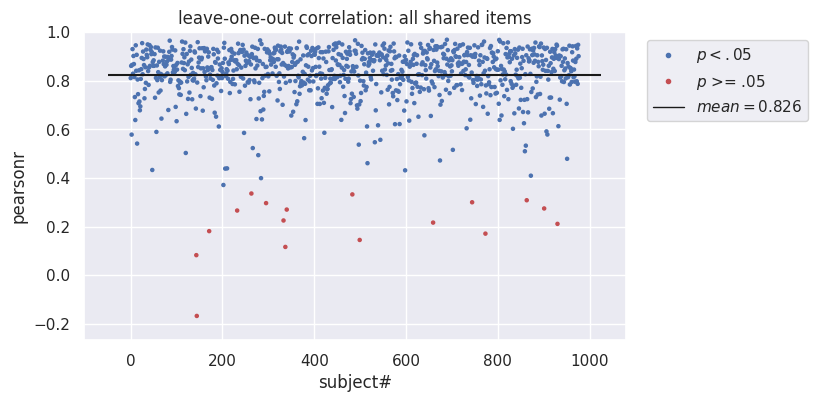

In [21]:
stats, pvals = np.array(stats), np.array(pvals)
c_ix = (pvals < 0.05).astype("int")
# c_ix = np.where(c_ix, '$p<.05$', '$p\\geq.05$')
cmap = matplotlib.colors.ListedColormap(("r", "b"))
c_ix = np.where(c_ix, "b", "r")

f, a = plt.subplots(figsize=(7, 4))
scatter = a.scatter(
    np.arange(N),
    stats,
    s=5,
    c=c_ix,  # cmap=cmap, # label=np.where(c_ix == 1, '$p<.05$', '$p>=.05$')
)
hlines = a.hlines(
    [np.mean(stats)], xmin=-N / 20, xmax=N + N / 20, colors=["k"], label="mean={}"
)

a.set(
    ylabel="pearsonr",
    xlabel="subject#",
    ylim=(min(stats) - 0.1, 1),
    title="leave-one-out correlation: all shared items",
)

from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker=".", label="$p<.05$", lw=0, color="b"),
    Line2D([0], [0], marker=".", label="$p$ >= $.05$", lw=0, color="r"),
    Line2D([0], [0], marker="", label=f"$mean={np.mean(stats):.3f}$", lw=1, color="k"),
]
a.legend(handles=legend_elements, loc="upper right", bbox_to_anchor=(1.35, 1.0))

# plt.tight_layout()
plt.show()

In [316]:
df2.to_csv("./cleaned_data/composlang-beh_no-dupes_loo-corr.csv")

In [574]:
leave_one_out_corr(view, subj_id, numpy=False)[0]

,age,rt,time_elapsed,trial_index,response
item_index,,,,,
12,31.125,4437.600,270837.000,12.0,1.550
18,31.125,3558.500,302770.450,18.0,2.975
25,31.125,5755.725,343303.200,25.0,-1.575
36,31.125,3682.775,414347.900,36.0,3.000
38,31.125,3862.750,422937.225,38.0,-2.650
50,31.125,4317.700,490679.875,50.0,-1.325
55,31.125,3488.925,517056.800,55.0,2.825
63,31.125,4661.325,553905.800,63.0,-0.675
73,31.125,2573.400,610436.600,73.0,3.000
